# Reverse Engineering the Zestimate

Denizens of San Francisco daydream about affordable housing. In me, this urge manifests as hours wasted browsing real estate listings near my home town in North Carolina. Zillow, a real estate website, provides a detailed estimate of home value, claiming that they are off on average by only $14,000.

So, I started scraping Zillow's listings for recently sold homes in NC, with two goals in mind: One, to verify the accuracy of their estimates, and two, to see how close to their models I could get with a weekend of work.

In [69]:
import numpy as np
import pandas as pd
import tensorflow as tf

from keras import models, layers, optimizers, backend, callbacks
from sklearn import ensemble
from sklearn import linear_model

import zillow

%matplotlib inline
from IPython.core.pylabtools import figsize
from seaborn import plt

# Load and Inspect Data

In [70]:
df = zillow.LoadTabularData("data/")

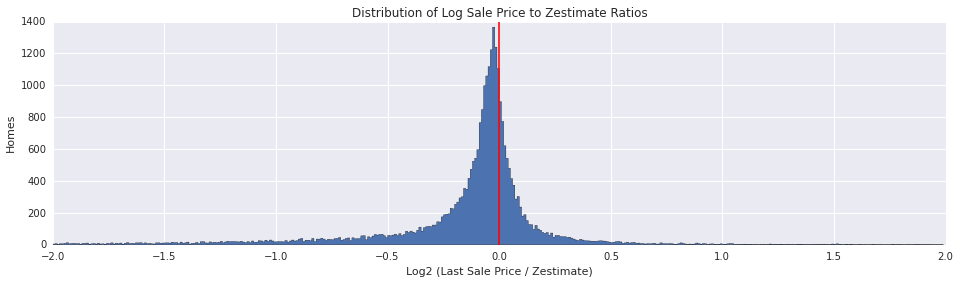

In [310]:
figsize(16, 4)
plt.hist(
    df.log_sold_to_zestimate, bins=np.arange(-2, 2, 0.01),
    histtype="stepfilled")
plt.vlines(0, 0, 1500, edgecolor="red", alpha=0.9)
plt.ylabel("Homes")
plt.xlabel("Log2 (Last Sale Price / Zestimate)")
plt.title("Distribution of Log Sale Price to Zestimate Ratios")
plt.ylim(0, 1400)
plt.show()

In [307]:
print "  Mean Zestimate Error: ${:.2f}k".format(
    (df.zestimate - df.last_sold).abs().mean() / 1000.0)
print "Median Zestimate Error: ${:.2f}k".format(
    (df.zestimate - df.last_sold).abs().median() / 1000.0)

  Mean Zestimate Error: $38.33k
Median Zestimate Error: $13.90k


It looks like, yes, 50% of Zillow's estimates are within $14k of the actual sale price!

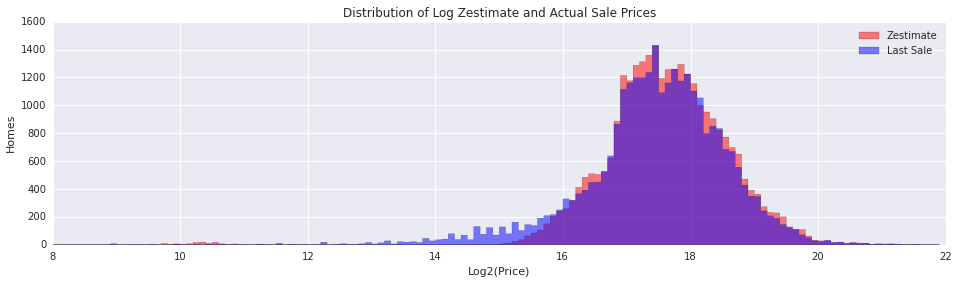

In [311]:
figsize(16, 4)
plt.hist(
    np.log2(df.zestimate), bins=np.arange(8, 22, 0.1),
    color="red", alpha=0.5, histtype="stepfilled", label="Zestimate")
plt.hist(
    np.log2(df.last_sold), bins=np.arange(8, 22, 0.1),
    color="blue", alpha=0.5, histtype="stepfilled", label="Last Sale")
plt.xlabel("Log2(Price)")
plt.ylabel("Homes")
plt.title("Distribution of Log Zestimate and Actual Sale Prices")
plt.legend()
plt.show()

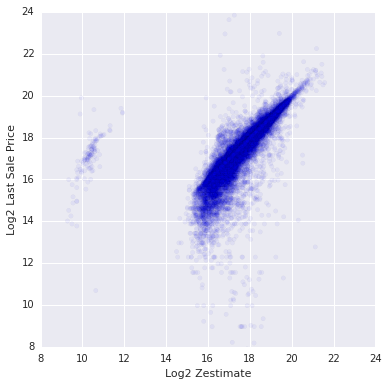

In [76]:
figsize(6, 6)
plt.scatter(np.log2(df.zestimate), np.log2(df.last_sold), alpha=0.05)
plt.xlabel("Log2 Zestimate")
plt.ylabel("Log2 Last Sale Price")
plt.xlim(8, 24)
plt.ylim(8, 24)
plt.show()

How does price different across communities?

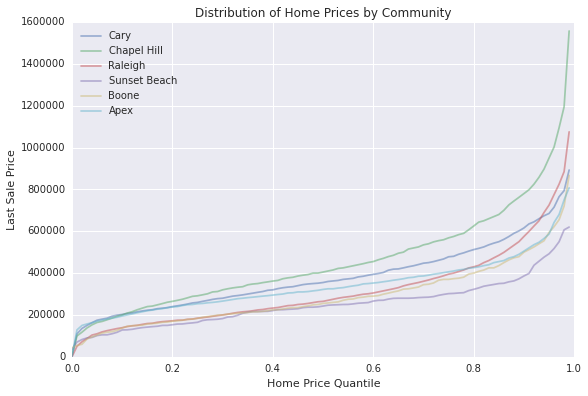

In [312]:
QUANTILES = np.arange(0, 1, 0.01)

def GetSaleQuantilesForCity(city):
    return df[df.city == city].last_sold.quantile(QUANTILES)

figsize(9, 6)
for city in ("Cary", "Chapel Hill", "Raleigh", "Sunset Beach", "Boone", "Apex"):
    plt.plot(
        QUANTILES, GetSaleQuantilesForCity(city),
        label=city, alpha=0.5)
plt.legend(loc="upper left")
plt.xlabel("Home Price Quantile")
plt.ylabel("Last Sale Price")
plt.title("Distribution of Home Prices by Community")
plt.show()

# Prepare Data for Training
#### Encode Zip Codes as Indices
We'll use these indices when embedding zip codes in latent spaces later on.

In [79]:
df["region"] = df.city + df.state + df.zip.astype(str)
region_encoder = dict((r, n) for n, r in enumerate(df.region.unique()))
df["region_code"] = df.region.map(lambda r: region_encoder[r])

#### Vectorize Regions and Home Facts
We create a vector of sparse binary features, each corresponding to either a region (city + state + zip) or a common property of homes. We call a property common if it appears at least 100 times in our sample.

In [317]:
vectorizer, vf = zillow.VectorizeFacts(df.region.map(lambda r: [r]) + df.facts)

# And a vectorization of properties only, without regions
_, vp = zillow.VectorizeFacts(df.facts)

#### Extract floor and lot sizes

In [319]:
df["floor_size"], df["lot_size"] = zip(*df.facts.map(zillow.FloorAndLotSize))

#### Split Data Into Training and Validation Sets
90% training, 10% validation.

In [316]:
ixs = np.arange(df.shape[0])
np.random.shuffle(ixs)
n_test = int(df.shape[0] / 10)
test_ixs = ixs[:n_test]
train_ixs = ixs[n_test:]
test_df = df.iloc[test_ixs]
train_df = df.iloc[train_ixs]

# Traditional ML & Statistical Models Trained on Home Facts

When approaching a new machine learning problem, before I get cute, I like to see how a handful of out-of-the-box prepackaged algorithms handle it.

We'll be training our models to predict the log base 2 of a house's sale price, as final home prices are approximately normally distributed when log transformed.

In [323]:
def ReportResults(preds, modelname):
    figsize(6, 6)
    plt.scatter(
        np.log2(df.zestimate[test_ixs]), np.log2(df.last_sold[test_ixs]),
        color="red", label="Zestimate", alpha=0.1)
    plt.scatter(
        preds, np.log2(df.last_sold[test_ixs]),
        color="blue", label=modelname, alpha=0.1)
    plt.xlabel("Log2 Predictions")
    plt.ylabel("Log2 Last Sale Price")
    plt.xlim(8, 24)
    plt.ylim(8, 24)
    plt.legend(loc="upper left")
    plt.show()

    print "  Mean Zestimate Error: ${:.2f}k".format(
        (np.exp2(preds) - test_df.last_sold).abs().mean() / 1000.0)
    print "Median Zestimate Error: ${:.2f}k".format(
        (np.exp2(preds) - test_df.last_sold).abs().median() / 1000.0)

### Random Forest Regression

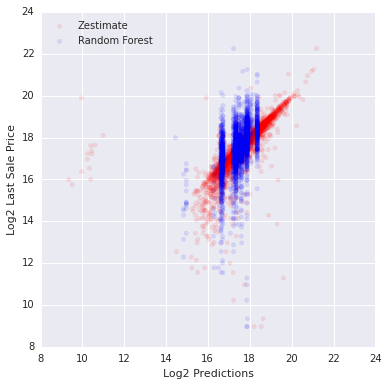

  Mean Zestimate Error: $107.35k
Median Zestimate Error: $60.84k


In [324]:
rfr = ensemble.RandomForestRegressor(n_estimators=100, max_leaf_nodes=10, n_jobs=-1)
rfr.fit(vf[train_ixs], np.log2(df.last_sold[train_ixs]))
rfr_preds = rfr.predict(vf[test_ixs])
ReportResults(rfr_preds, "Random Forest")

### Ordinary Least Squares Regression

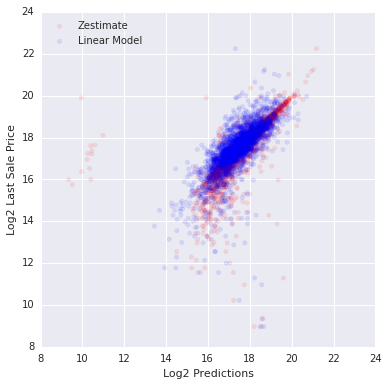

  Mean Zestimate Error: $82.23k
Median Zestimate Error: $41.94k


In [325]:
olsr = linear_model.LinearRegression(n_jobs=-1)
olsr.fit(vf[train_ixs], np.log2(df.last_sold[train_ixs]))
olsr_preds = olsr.predict(vf[test_ixs])
ReportResults(olsr_preds, "Linear Model")

### Ridge Regression

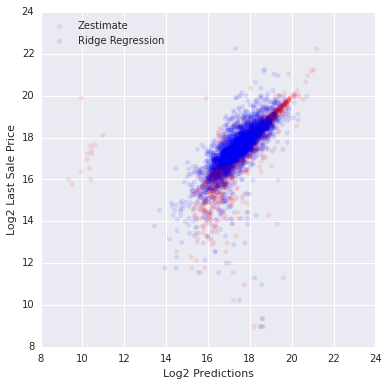

  Mean Zestimate Error: $82.09k
Median Zestimate Error: $41.66k


In [326]:
rr = linear_model.Ridge()
rr.fit(vf[train_ixs], np.log2(train_df.last_sold))
rr_preds = rr.predict(vf[test_ixs])
ReportResults(rr_preds, "Ridge Regression")

# Deep Learning Models

The poor performance of traditional methods justifies trying something more interesting, just as I'd hoped!

In [330]:
def VisualizeTraining(history, ymin=0.0, ymax=3):
    hist = history.history
    n_epochs = len(hist["loss"])
    figsize(12, 4)
    plt.plot(
        np.arange(n_epochs), hist["loss"],
        alpha=0.5, label="Training Loss")
    plt.plot(
        np.arange(n_epochs), hist["val_loss"],
        alpha=0.5, label="Validation Loss")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss (squared difference in log price) By Epoch")
    plt.ylim(ymin, ymax)
    plt.show()

### Multi-Layer Dense Network
Our first model will be a simple multi-layer fully-connected network with the ELU (exponential linear unit) nonlinearity, and lots of dropout.

In [86]:
def FactRegressor(n_facts, hidden_sizes=[100, 50, 20], nonlin=layers.advanced_activations.ELU):
    model = models.Sequential()
    sizes = [n_facts] + hidden_sizes + [1]
    for i, (in_size, out_size) in enumerate(zip(sizes[:-1], sizes[1:])):
        if i > 0 and i < len(sizes) - 1:
            model.add(layers.Dropout(0.5))
        model.add(layers.Dense(out_size, input_dim=in_size))
        model.add(nonlin())
    return model

In [130]:
fr = FactRegressor(vf.shape[1], hidden_sizes=[256, 128, 64, 32, 16])

In [131]:
fr.compile(optimizer="adam", loss="mse")

In [132]:
fr_history = fr.fit(
    vf[train_ixs],
    np.array(np.log2(train_df.last_sold)),
    batch_size=128,
    nb_epoch=200,
    verbose=0,
    validation_data=(
        vf[test_ixs],
        np.array(np.log2(test_df.last_sold))),
    shuffle=True,
    callbacks=[callbacks.LearningRateScheduler(
        lambda ep: 0.001 if ep < 100 else 0.0001)])

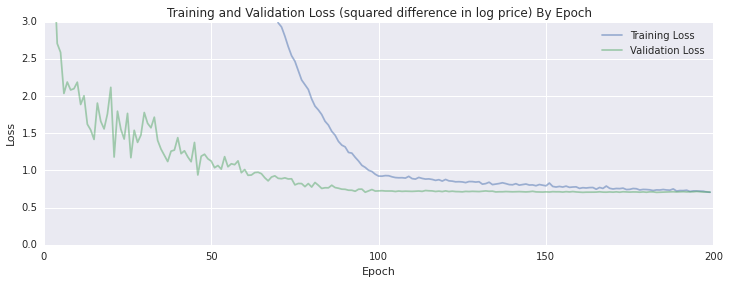

In [331]:
VisualizeTraining(fr_history)

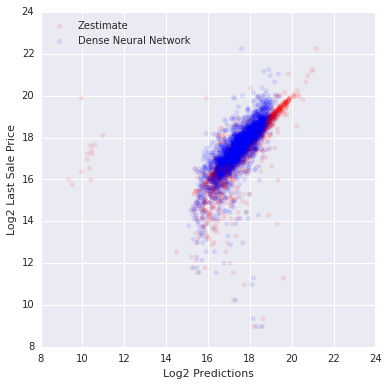

  Mean Zestimate Error: $74.73k
Median Zestimate Error: $37.28k


In [328]:
fr_preds = fr.predict(vf[test_ixs]).reshape((test_df.shape[0],))
ReportResults(fr_preds, "Dense Neural Network")

### Deanse Network with Regional Scale and Attention Mechanism
I hypothesize that different properties are given different weight in different regions. We'll break our feature vector up into two parts: first, binary features for home properties; and second, region embeddings.

The final output will be the sum of a regional bias, and home desirability value multiplied by a regional scale value.

Regional bias and scale will be learned from the region embeddings alone. Home desirability will be learned from home properties, as filtered through an attention matrix learned from the region embeddings.

```
█████████████████████            █████████████████████
█ region_embeddings █            █ binary_properties █
█████████████████████            █████████████████████
      |\__      \____________             *
      |   \__                \---- attention_matrix
      |      \__                          =
      |         \__                     hidden
      |            \                      |                █████████
regional_bias  +  (regional_scale  *  home_desirability) = █ price █
                                                           █████████
                                                           ```

In [96]:
def AttentiveRegressor(
        n_regions, n_facts,
        region_embedding_size=16,
        hidden_sizes=[128, 64, 32, 16],
        nonlin=layers.advanced_activations.ELU):
    # Embeddings
    embed = models.Sequential()
    embed.add(layers.embeddings.Embedding(n_regions, region_embedding_size, input_length=1))
    embed.add(layers.Reshape((region_embedding_size,)))
    embed.add(layers.Dropout(0.5))

    # Regional Mean
    reg_bias = models.Sequential()
    reg_bias.add(embed)
    reg_bias.add(layers.Dense(1))
    reg_bias.add(layers.Activation("relu"))
    reg_bias.add(layers.Lambda(lambda x: x + 1.0))

    # Regional Scale
    reg_scale = models.Sequential()
    reg_scale.add(embed)
    reg_scale.add(layers.Dense(1))
    reg_scale.add(layers.Activation("relu"))
    reg_scale.add(layers.Lambda(lambda x: x + 0.1))

    # Properties
    props = models.Sequential()
    props.add(layers.Reshape((n_facts,), input_shape=(n_facts,)))

    # Attention
    att = models.Sequential()
    att.add(embed)
    att.add(layers.Dense(n_facts))
    att.add(layers.Activation("sigmoid"))
    att_output = layers.Merge([att, props], mode="mul")

    # Home Desirability
    desire = models.Sequential()
    desire.add(att_output)
    sizes = [n_facts] + hidden_sizes + [1]
    for i, (in_size, out_size) in enumerate(zip(sizes[:-1], sizes[1:])):
        if i > 0 and i < len(sizes) - 1:
            desire.add(layers.Dropout(0.5))
        desire.add(layers.Dense(out_size, input_dim=in_size))
        if i < len(sizes) - 1:
            desire.add(nonlin())
        else:
            desire.add(layers.Activation("relu"))
            desire.add(layers.Lambda(lambda x: x + 1.0))

    # Output
    scale_x_desirability = layers.Merge([reg_scale, desire], mode="mul")
    raw_output = layers.Merge([reg_bias, scale_x_desirability], mode="sum")
    out = models.Sequential()
    out.add(raw_output)
    out.add(layers.Lambda(lambda x: tf.log(tf.maximum(x, 0.00001)) / np.log(2)))
    return out

In [120]:
ar = AttentiveRegressor(
    len(df.region.unique()), vp.shape[1],
    hidden_sizes=[256, 128, 64, 32, 16])

In [121]:
ar.compile(optimizer="adam", loss="mse")

In [122]:
ar_history = ar.fit(
    [train_df.region_code, vp[train_ixs]],
    np.array(np.log2(train_df.last_sold)),
    batch_size=128,
    nb_epoch=200,
    verbose=0,
    validation_data=(
        [test_df.region_code, vp[test_ixs]],
        np.array(np.log2(test_df.last_sold))),
    shuffle=True,
    callbacks=[callbacks.LearningRateScheduler(
        lambda ep: 0.001 if ep < 100 else 0.0001)])

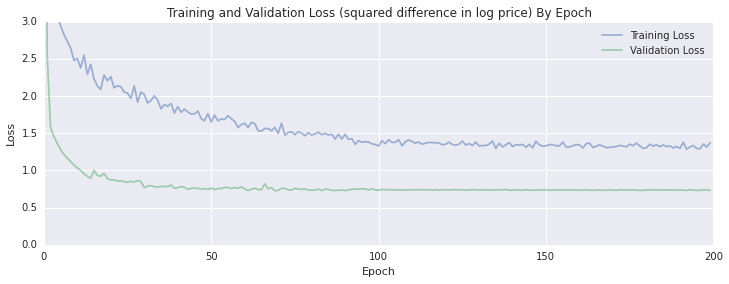

In [332]:
VisualizeTraining(ar_history)

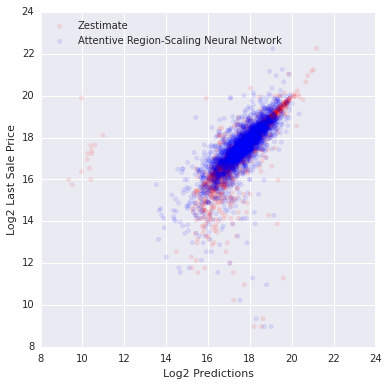

  Mean Zestimate Error: $77.89k
Median Zestimate Error: $41.08k


In [335]:
ar_preds = ar.predict([test_df.region_code, vp[test_ixs]]).reshape((test_df.shape[0],))
ReportResults(ar_preds, "Attentive Region-Scaling Neural Network")

### Deanse Network with Regional Scale but No Attention Mechanism
Maybe the regional bias and scale are useful, but the attention mechanism is not? Architecture of the "inattentive network":

```
█████████████████████            █████████████████████
█ region_embeddings █            █ binary_properties █
█████████████████████            █████████████████████
      |\__                                |
      |   \__                             |
      |      \__                        hidden
      |         \__                       |
      |            \                      |                █████████
regional_bias  +  (regional_scale  *  home_desirability) = █ price █
                                                           █████████
                                                           ```

In [124]:
def InattentiveRegressor(
        n_regions, n_facts,
        region_embedding_size=16,
        hidden_sizes=[128, 64, 32, 16],
        nonlin=layers.advanced_activations.ELU):
    # Embeddings
    embed = models.Sequential()
    embed.add(layers.embeddings.Embedding(n_regions, region_embedding_size, input_length=1))
    embed.add(layers.Reshape((region_embedding_size,)))
    embed.add(layers.Dropout(0.5))

    # Regional Mean
    reg_bias = models.Sequential()
    reg_bias.add(embed)
    reg_bias.add(layers.Dense(1))
    reg_bias.add(layers.Activation("relu"))
    reg_bias.add(layers.Lambda(lambda x: x + 1.0))

    # Regional Scale
    reg_scale = models.Sequential()
    reg_scale.add(embed)
    reg_scale.add(layers.Dense(1))
    reg_scale.add(layers.Activation("relu"))
    reg_scale.add(layers.Lambda(lambda x: x + 0.1))

    # Properties
    props = models.Sequential()
    sizes = [n_facts] + hidden_sizes + [1]
    for i, (in_size, out_size) in enumerate(zip(sizes[:-1], sizes[1:])):
        if i > 0 and i < len(sizes) - 1:
            props.add(layers.Dropout(0.5))
        props.add(layers.Dense(out_size, input_dim=in_size))
        if i < len(sizes) - 1:
            props.add(nonlin())
        else:
            props.add(layers.Activation("relu"))
            props.add(layers.Lambda(lambda x: x + 1.0))

    # Output
    scale_x_desirability = layers.Merge([reg_scale, props], mode="mul")
    raw_output = layers.Merge([reg_bias, scale_x_desirability], mode="sum")
    out = models.Sequential()
    out.add(raw_output)
    out.add(layers.Lambda(lambda x: tf.log(tf.maximum(x, 0.00001)) / np.log(2)))
    return out

In [125]:
iar = InattentiveRegressor(
    len(df.region.unique()), vp.shape[1],
    hidden_sizes=[256, 128, 64, 32, 16])

In [126]:
iar.compile(optimizer="adam", loss="mse")

In [127]:
iar_history = iar.fit(
    [train_df.region_code, vp[train_ixs]],
    np.array(np.log2(train_df.last_sold)),
    batch_size=128,
    nb_epoch=200,
    verbose=0,
    validation_data=(
        [test_df.region_code, vp[test_ixs]],
        np.array(np.log2(test_df.last_sold))),
    shuffle=True,
    callbacks=[callbacks.LearningRateScheduler(
        lambda ep: 0.001 if ep < 100 else 0.0001)])

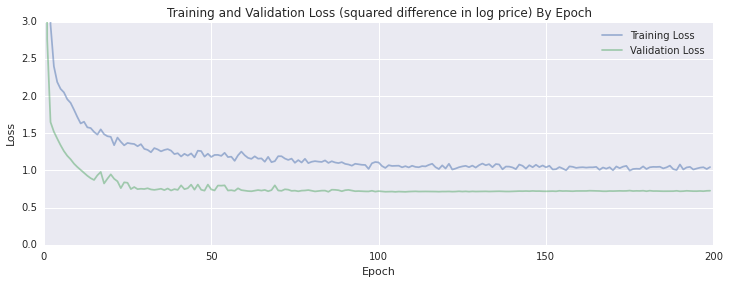

In [337]:
VisualizeTraining(iar_history)

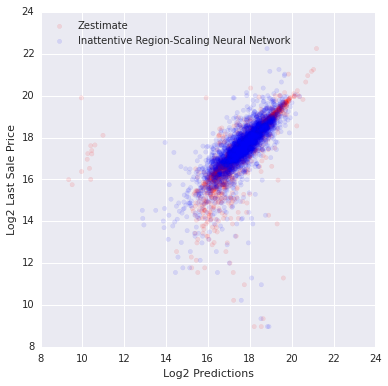

  Mean Zestimate Error: $78.88k
Median Zestimate Error: $43.05k


In [338]:
iar_preds = iar.predict([test_df.region_code, vp[test_ixs]]).reshape((test_df.shape[0],))
ReportResults(iar_preds, "Inattentive Region-Scaling Neural Network")

### Deanse Network with Floor Size Scale
Maybe what we should really be predicting is cost per square foot! (Actually, I'm a bit embarrassed I didn't start out doing this. It's sort of obvious.)

Assume that each feature of the home (including zip code) can either contribute a flat amount to the value of the house, or make each square foot of house more valubale.

```
█████████████████████
█ binary_home_facts █
█████████████████████
       ___|___
      /       \              ██████████████     █████████
   bonus + (value_per_sqft * █ floor_size █ ) = █ price █
                             ██████████████     █████████
```

In [270]:
def CostPerSquareFootRegressor(
        n_facts,
        hidden_sizes=[128, 64, 32, 16],
        nonlin=layers.advanced_activations.ELU):
    hidden = models.Sequential()
    sizes = [n_facts] + hidden_sizes
    for i, (in_size, out_size) in enumerate(zip(sizes[:-1], sizes[1:])):
        if i > 0:
            hidden.add(layers.Dropout(0.5))
        hidden.add(layers.Dense(out_size, input_dim=in_size))
        hidden.add(nonlin())

    # Un-scaled bonus, restricted to $0-$100k
    bonus = models.Sequential()
    bonus.add(hidden)
    bonus.add(layers.Dropout(0.5))
    bonus.add(layers.Dense(1))
    bonus.add(layers.Activation("sigmoid"))
    bonus.add(layers.Lambda(lambda x: x * 100 * 1000))

    # Cost per Squre Foot Multiplier
    multiplier = models.Sequential()
    multiplier.add(hidden)
    multiplier.add(layers.Dropout(0.5))
    multiplier.add(layers.Dense(1))
    multiplier.add(layers.Activation("relu"))

    # Floor size
    sqft = models.Sequential()
    sqft.add(layers.Reshape((1,), input_shape=(1,)))

    # Output
    sqft_x_multiplier = layers.Merge([sqft, multiplier], mode="mul")
    raw_output = layers.Merge([bonus, sqft_x_multiplier], mode="sum")
    out = models.Sequential()
    out.add(raw_output)
    out.add(layers.Lambda(lambda x: tf.log(tf.maximum(x, 0.00001)) / np.log(2)))
    return out

In [275]:
cpsfr = CostPerSquareFootRegressor(
    vf.shape[1],
    hidden_sizes=[256, 128, 64, 32, 16])

In [276]:
cpsfr.compile(optimizer="adam", loss="mse")

In [277]:
cpsfr_history = cpsfr.fit(
    [vf[train_ixs], df.floor_size[train_ixs]],
    np.array(np.log2(train_df.last_sold)),
    batch_size=128,
    nb_epoch=50,
    verbose=0,
    validation_data=(
        [vf[test_ixs], df.floor_size[test_ixs]],
        np.array(np.log2(test_df.last_sold))),
    shuffle=True,
    callbacks=[callbacks.LearningRateScheduler(
        lambda ep: 0.001 if ep < 20 else 0.0001)])

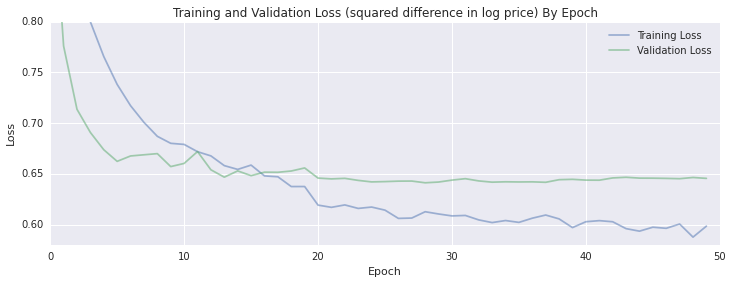

In [341]:
VisualizeTraining(cpsfr_history, ymin=0.58, ymax=0.8)

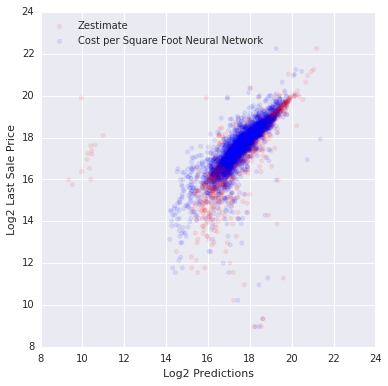

  Mean Zestimate Error: $64.12k
Median Zestimate Error: $31.54k


In [342]:
cpsfr_preds = cpsfr.predict(
    [vf[test_ixs], df.floor_size[test_ixs]]).reshape((test_df.shape[0],))
ReportResults(cpsfr_preds, "Cost per Square Foot Neural Network")

# Model Results Comparison
How do my methods stack up, to each other and to the Zestimate?

In [280]:
model_names = [
    "zestimate",
    "dense network", "attentive network", "inattentive network",
    "cost per sqft network",
    "ridge regression", "linear regression", "random forest regression"]
log2_preds_by_model = [
    np.log2(test_df.zestimate),
    fr_preds, ar_preds, iar_preds,
    cpsfr_preds,
    rr_preds, olsr_preds, rfr_preds]
preds_by_model = [np.exp2(preds) for preds in log2_preds_by_model]
targets = test_df.last_sold
log2_targets = np.log2(targets)
results_df = pd.DataFrame({
    "model": model_names,
    "mean abs log2 err": [
        (preds - log2_targets).abs().mean()
        for preds in log2_preds_by_model],
    "mean abs error": [
        (preds - targets).abs().mean()
        for preds in preds_by_model],
    "median abs error": [
        (preds - targets).abs().median()
        for preds in preds_by_model],
    "median error %": [
        round(((preds - targets) / targets).abs().median() * 100, 2)
        for preds in preds_by_model]})
results_df.sort_values("mean abs error")

,mean abs error,mean abs log2 err,median abs error,median error %,model
0,41755.847967,0.330889,14158.000000,6.56,zestimate
4,64119.421056,0.422549,31541.234375,16.96,cost per sqft network
1,74730.458662,0.480979,37275.621094,20.62,dense network
2,77889.213595,0.493650,41082.343750,23.26,attentive network
3,78879.918749,0.494571,43054.656250,23.45,inattentive network
5,82093.354829,0.517441,41664.881956,23.62,ridge regression
6,82234.328177,0.517977,41936.792204,23.69,linear regression
7,107319.779593,0.713248,61222.206323,34.27,random forest regression


In [ ]:
### Network Convergence
And how quickly 

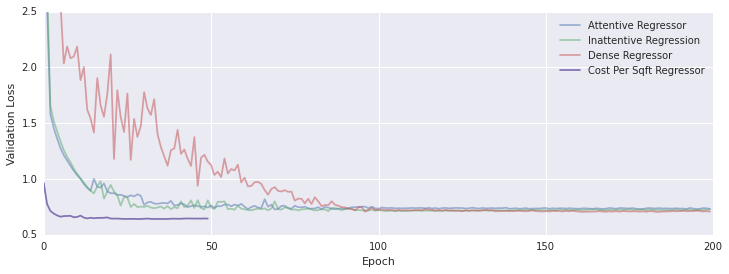

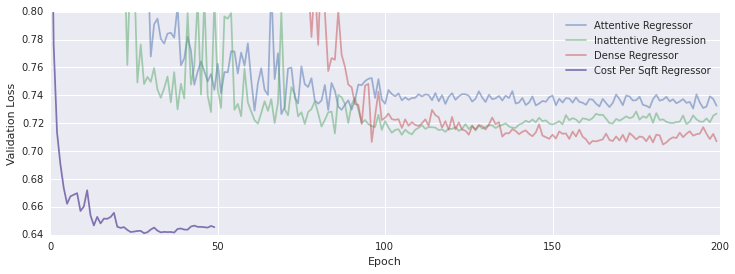

In [292]:
figsize(12, 4)
plt.plot(
    np.arange(200), ar_history.history["val_loss"],
    alpha=0.5, label="Attentive Regressor")
plt.plot(
    np.arange(200), iar_history.history["val_loss"],
    alpha=0.5, label="Inattentive Regression")
plt.plot(
    np.arange(200), fr_history.history["val_loss"],
    alpha=0.5, label="Dense Regressor")
plt.plot(
    np.arange(50), cpsfr_history.history["val_loss"],
    alpha=1.0, label="Cost Per Sqft Regressor")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.ylim(0.5, 2.5)
plt.show()

plt.plot(
    np.arange(200), ar_history.history["val_loss"],
    alpha=0.5, label="Attentive Regressor")
plt.plot(
    np.arange(200), iar_history.history["val_loss"],
    alpha=0.5, label="Inattentive Regression")
plt.plot(
    np.arange(200), fr_history.history["val_loss"],
    alpha=0.5, label="Dense Regressor")
plt.plot(
    np.arange(50), cpsfr_history.history["val_loss"],
    alpha=1.0, label="Cost Per Sqft Regressor")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.ylim(0.64, 0.8)
plt.show()